In [1]:
%load_ext autoreload
%autoreload 2

In [156]:
from pdf2image import convert_from_path
from PIL import Image
import numpy as np
from matplotlib.colors import rgb_to_hsv
import colorsys
import img2pdf
import os
import cv2
import remove_red_banners
from importlib import reload
import matplotlib.pyplot as plt
reload(remove_red_banners) 

[autoreload of remove_red_banners failed: Traceback (most recent call last):
  File "D:\Uniud\appunti-universitari\.notesVenv\Lib\site-packages\IPython\extensions\autoreload.py", line 280, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Uniud\appunti-universitari\.notesVenv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 533, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Users\londe\AppData\Local\Programs\Python\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 3158: character maps to <undefined>
]


<module 'remove_red_banners' from 'D:\\Uniud\\appunti-universitari\\tecnologie_web_per_il_cloud\\lucidi\\remove_red_banners.py'>

In [77]:
INPUT_PDF = "11-SOA.pdf"
OUTPUT_PDF = f"{INPUT_PDF[:INPUT_PDF.rfind('.')]}_cleaned.pdf"
TEMP_FOLDER = "temp_images"
os.makedirs(TEMP_FOLDER, exist_ok=True)
pages = convert_from_path(INPUT_PDF, dpi=200, poppler_path=r"C:\Program Files\poppler-24.08.0\Library\bin")

None 0 [0, 0, 0]
[0 1]
refee


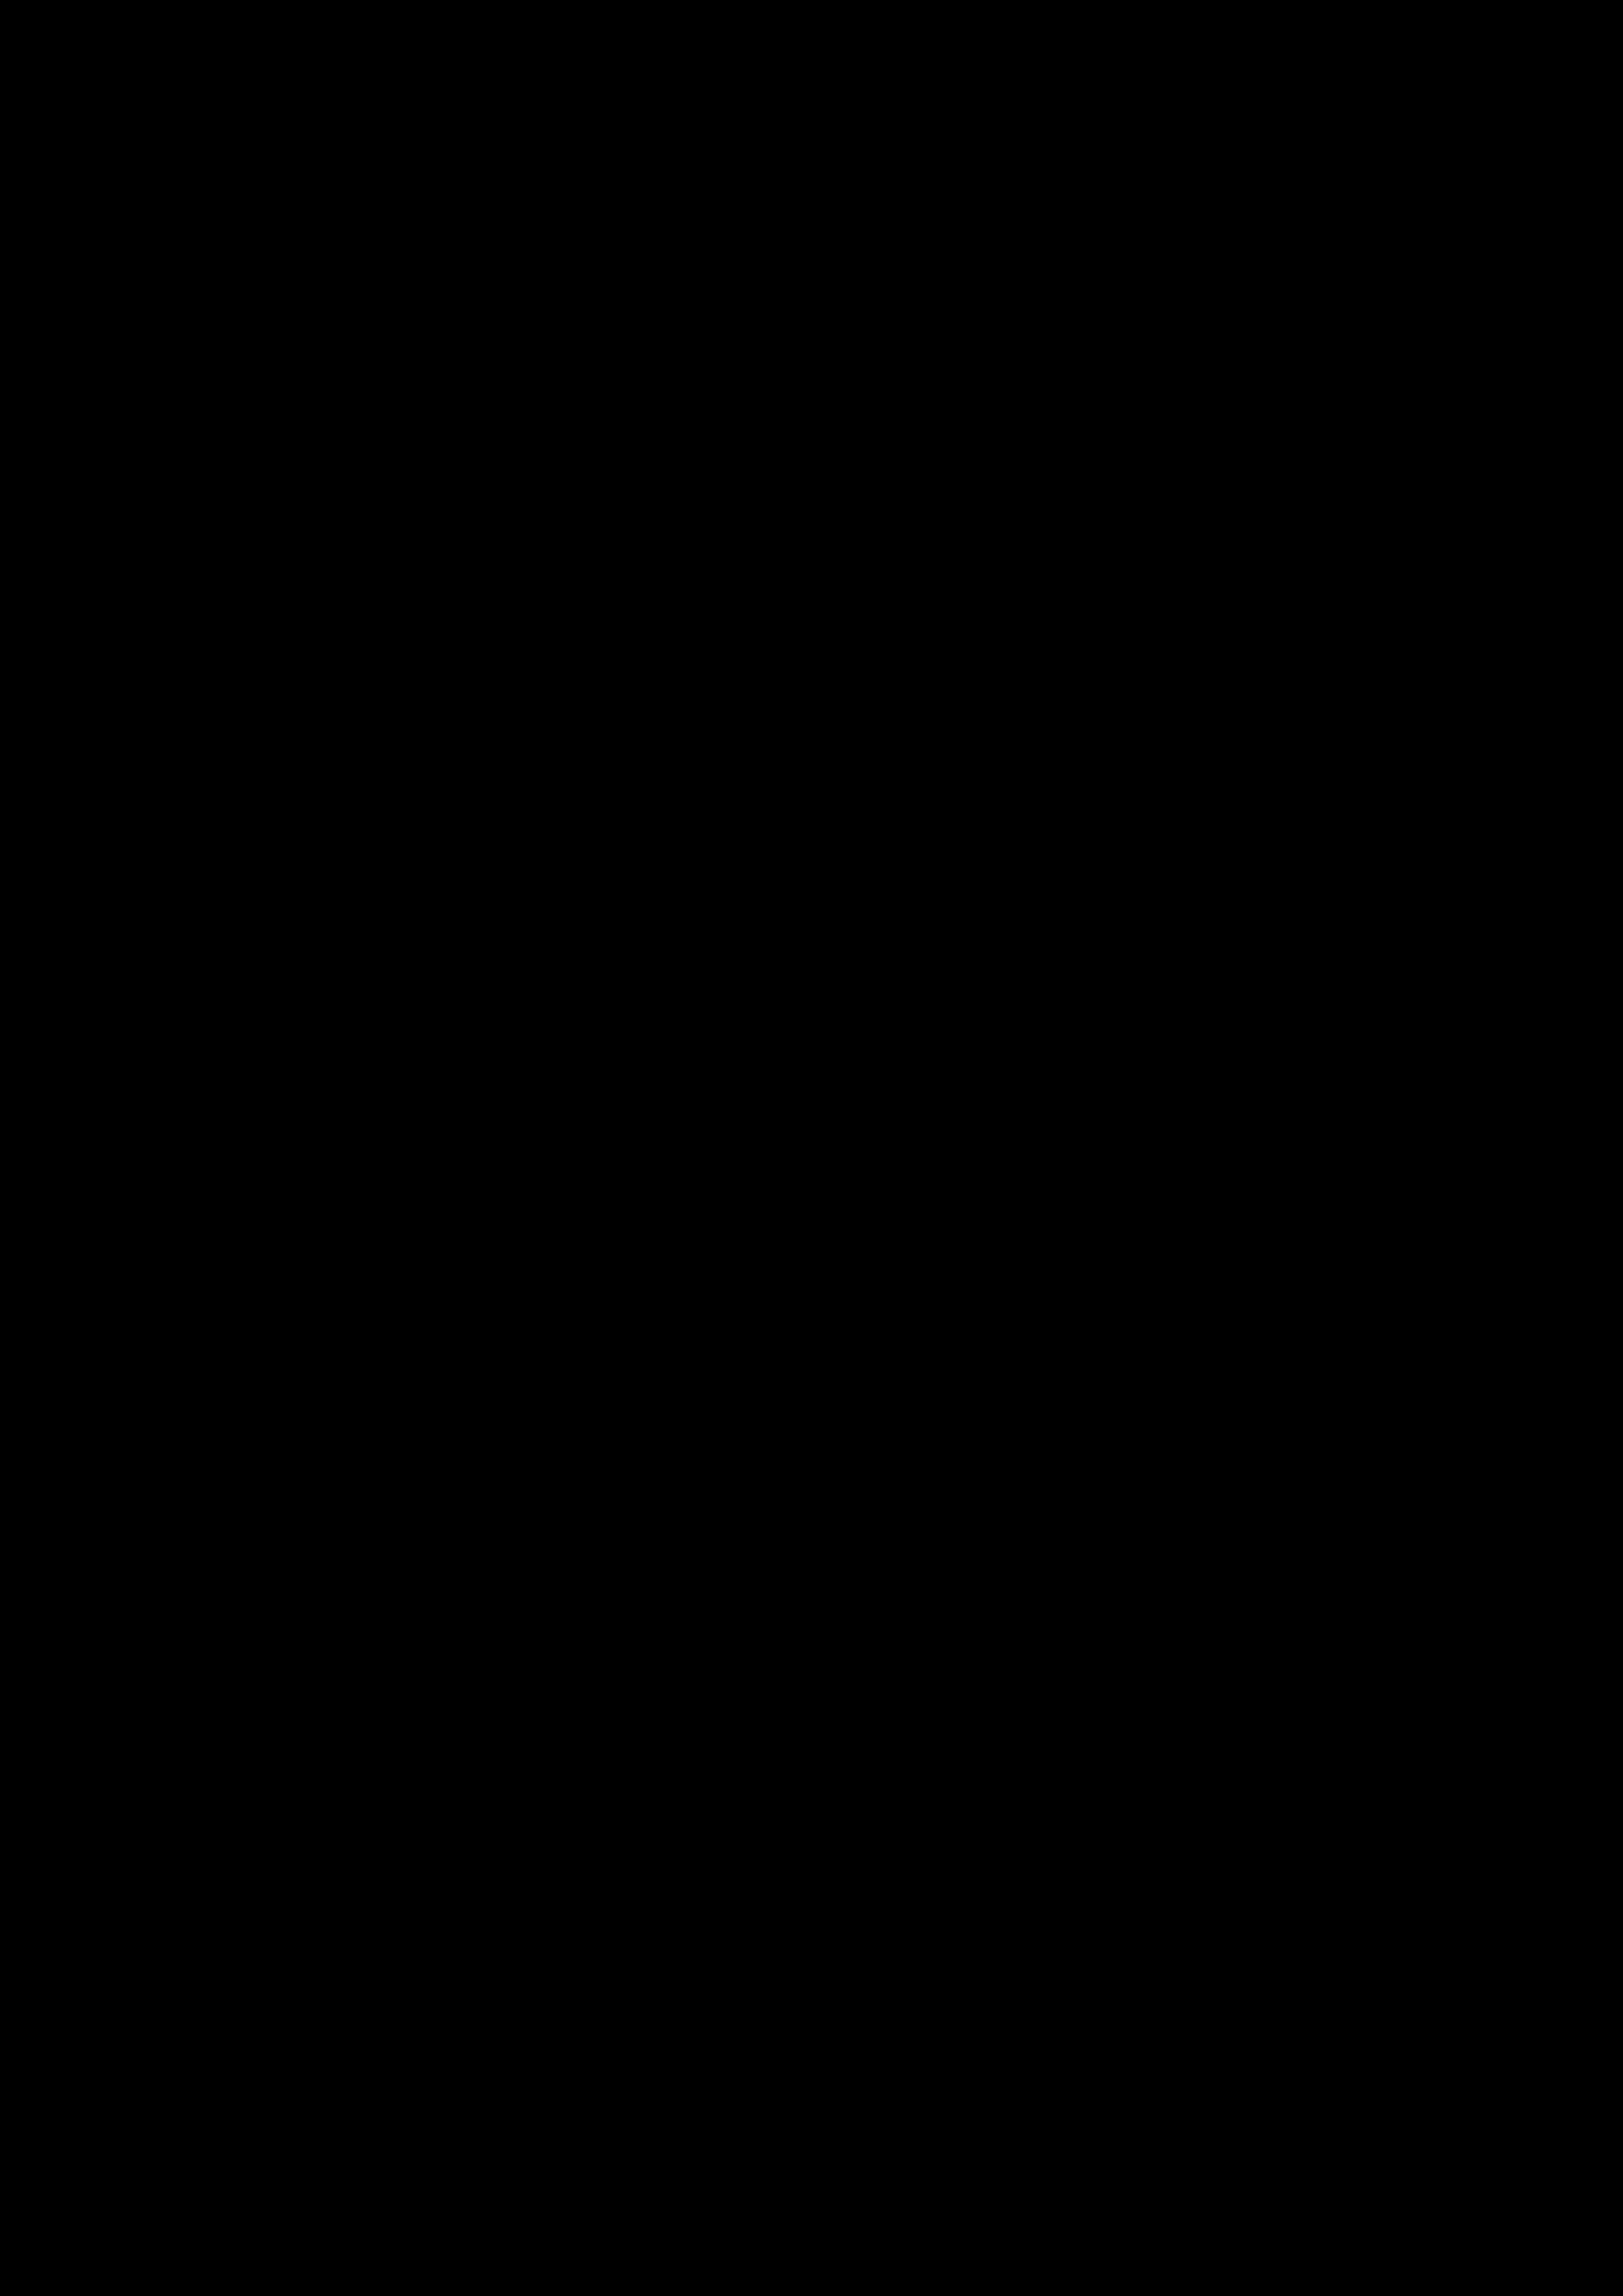

In [157]:
remove_red_banners.apply_cleanup(pages[9], remove_red_banners.BoxDetectionMode.CHUNK, compute_as_gray = True, show_preview_boxes= False, dark_block_lux_threshold_level = (73-20, 73+20), merge_chunks_with_dbscan = True, show_boxes_number = False, debug = True)[0]

In [18]:
bounding_args = remove_red_banners.ChunkBoxArgs(use_erode=False, erode_kernel_size= (3, 3), erode_iterations=1, chunk_size=5, ligth_upper_level=180, density_thresh=0.9,
                 dbscan_eps=10, dbscan_min_samples=4)

In [375]:
binary_mask = remove_red_banners.compute_dark_mask(remove_red_banners.to_grayscale_array(pages[9]), 200)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded = cv2.erode(binary_mask.astype(np.uint8) * 255, kernel, iterations=1)
eroded_img = Image.fromarray(~eroded)

boxes = remove_red_banners.connected_component_boxes(remove_red_banners.compute_dark_mask(remove_red_banners.to_grayscale_array(eroded_img), 200).astype(np.uint8) * 255, 500)

1068
7


In [302]:
type(np.array(2))

numpy.ndarray

In [294]:
Image

<module 'PIL.Image' from 'D:\\Uniud\\appunti-universitari\\.notesVenv\\Lib\\site-packages\\PIL\\Image.py'>

In [304]:
isinstance(np.array(129), np.ndarray)

True

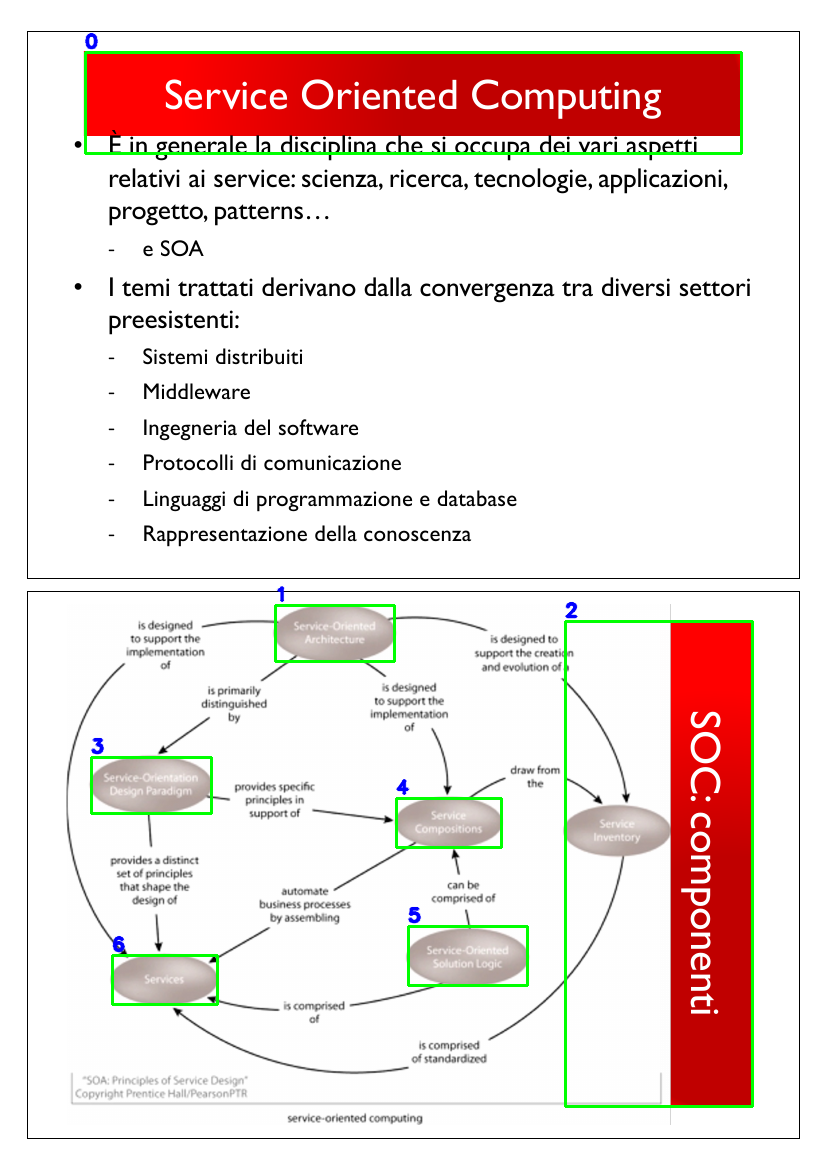

In [376]:
image = remove_red_banners.to_rgb_array(pages[9])
for i, (x, y, w, h) in enumerate(boxes):
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(
                image,      # immagine
                str(i),                                  # testo da scrivere
                (x, max(y - 5, 5)),                               # posizione (leggermente sopra il box)
                cv2.FONT_HERSHEY_SIMPLEX,                # font
                0.6,                                      # scala del font
                (0, 0, 255),                              # colore (rosso)
                2,                                        # spessore del tratto
                cv2.LINE_AA                               # tipo di linea (anti-alias)
            )
Image.fromarray(image)

In [282]:
bounding_args = remove_red_banners.ConnectedBoxArgs(
    use_erode=True, erode_kernel_size=(4, 4), erode_iterations=1, 
    use_inblock_erode=True, inblock_erode_kernel_size=(3, 3), inblock_erode_iterations=2, 
    use_dilate=True, dilate_kernel_size=(3, 3), dilate_iterations= 1, 
    ligth_upper_level=200, min_area=800
)

In [223]:
img, eroded = remove_red_banners.show_dark_bounding_boxes(pages[9],  bounding_args, as_gray= True, show_density_block= False, show_numbers = True)

159
7


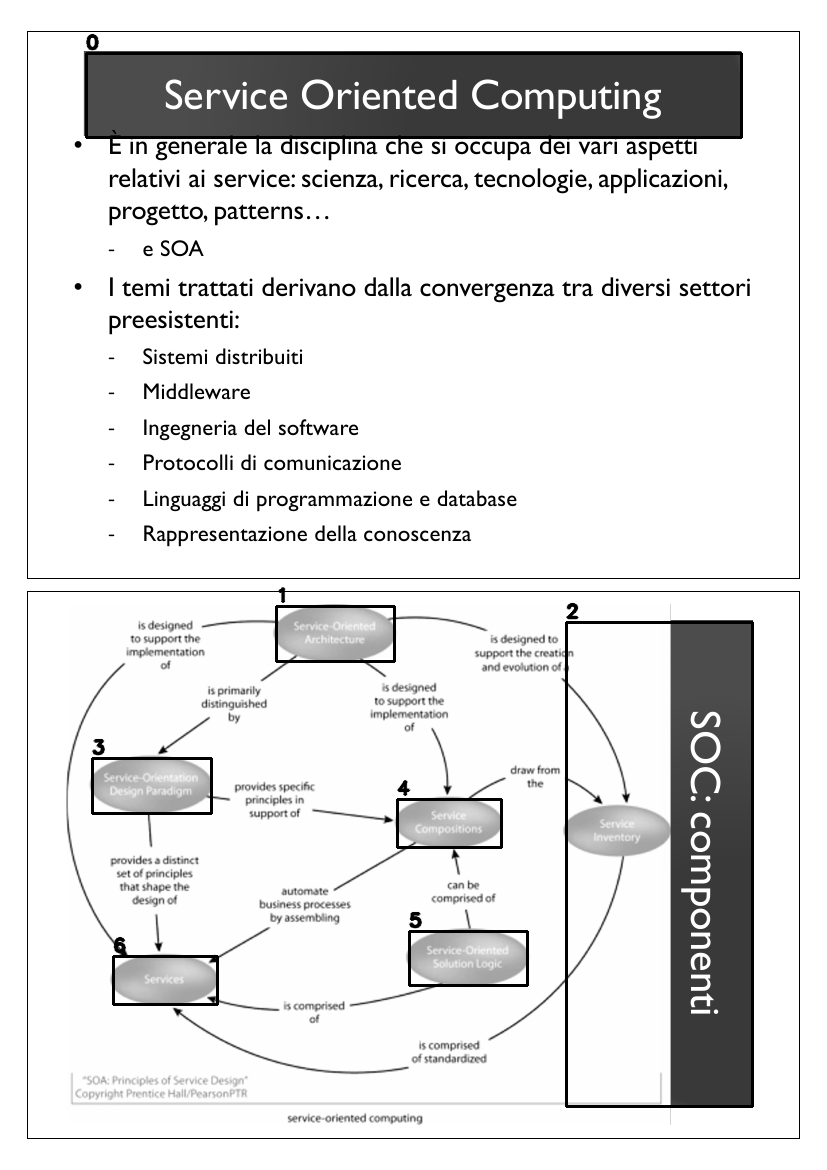

In [224]:
img#Image.fromarray(eroded)

150
5


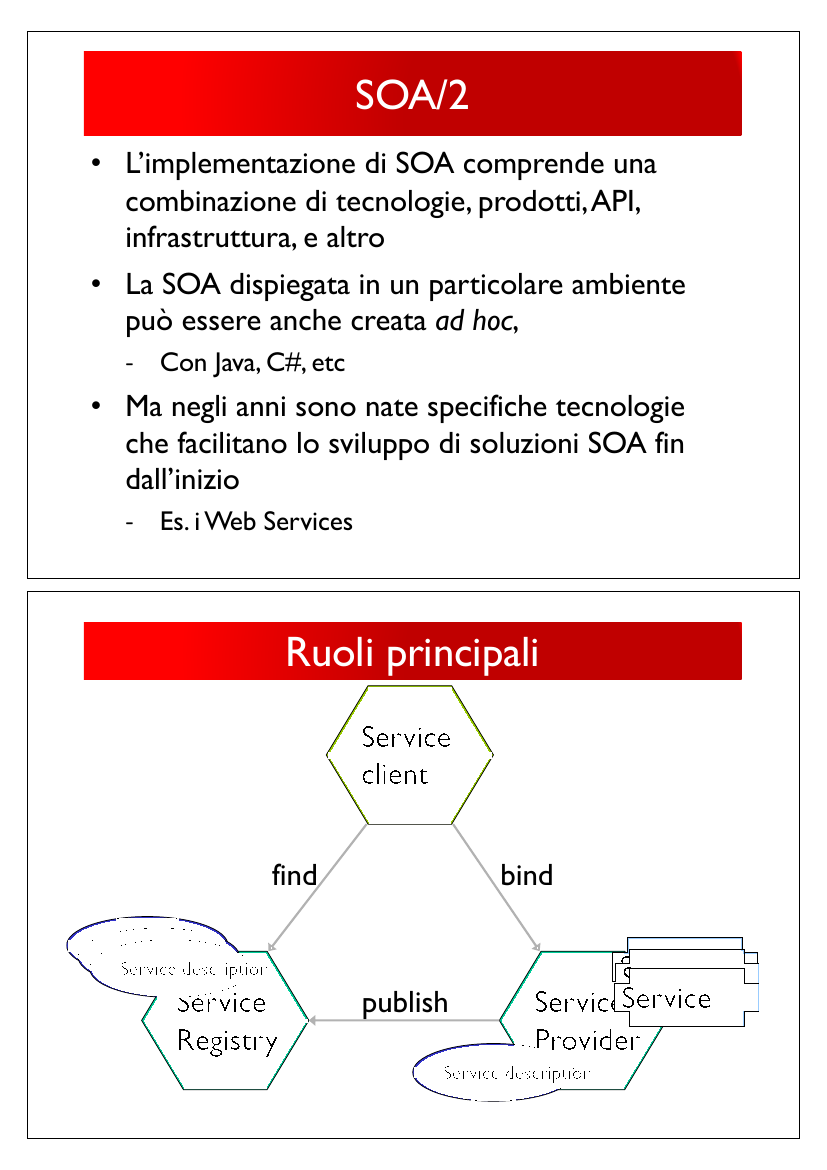

In [283]:
remove_red_banners.apply_cleanup(pages[14], bounding_args, inner_text_s_thresh= (0, 0.05), inner_text_v_thresh= (0, 0.05), min_text_density=0.001)

In [285]:

def interactive_debug(pages, box_args):
    page_index = 0
    current_params = {
        "inner_text_s_thresh": (None, 0.25),
        "inner_text_v_thresh": (0.85, None),
        "min_text_density": 0.4,
        "debug": False
    }

    while True:
        print(f"\n=== Pagina {page_index+1}/{len(pages)} ===")
        cmd = input("Comandi: [v]iew | [vd]ebug | [mb] modify block | [p]rev | [n]ext | [set] parameters | [Q]uit\n> ").strip()

        if cmd.lower() == 'q':
            break

        elif cmd.lower() == 'v':
            display(pages[page_index])

        elif cmd.lower() == 'vd':
            image = pages[page_index].convert("RGB")
            rgb = np.array(image)
            gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
            mask = compute_dark_mask(gray, 200).astype(np.uint8) * 255
            boxes = connected_component_boxes(mask, min_area=150)
            vis = rgb.copy()
            for i, (x, y, w, h) in enumerate(boxes):
                cv2.rectangle(vis, (x, y), (x+w, y+h), (0,255,0), 2)
                cv2.putText(vis, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

            display(Image.fromarray(vis))

        elif cmd.lower().startswith('mb'):
            image = pages[page_index].convert("RGB")
            rgb = np.array(image)
            gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
            mask = compute_dark_mask(gray, 200).astype(np.uint8) * 255
            boxes = connected_component_boxes(mask, min_area=150)

            print(f"Totale blocchi: {len(boxes)}")
            ids = input("Inserisci ID blocchi separati da virgola (es. 0,2,5): ")
            ids = [int(i.strip()) for i in ids.split(",") if i.strip().isdigit()]

            vis = rgb.copy()
            for idx in ids:
                x, y, w, h = boxes[idx]
                block = vis[y:y+h, x:x+w]
                cleaned = clean_dark_block(block, box_args, **current_params)
                vis[y:y+h, x:x+w] = cleaned

            display(Image.fromarray(vis))

        elif cmd.lower() == 'set':
            for k in current_params:
                val = input(f"{k} = {current_params[k]} → nuovo valore (ENTER per saltare): ")
                if val.strip() == '':
                    continue
                try:
                    if k.endswith('_thresh'):
                        # può essere una tupla
                        if val.strip().lower() == "none":
                            current_params[k] = (None, None)
                        else:
                            t = tuple(float(v.strip()) if v.strip().lower() != 'none' else None for v in val.strip().split(','))
                            current_params[k] = t
                    elif k == "debug":
                        current_params[k] = val.lower() in ['true', '1', 'yes']
                    else:
                        current_params[k] = float(val)
                except Exception as e:
                    print(f"Errore: {e}")
        
        elif cmd.lower() == 'n':
            page_index = min(page_index + 1, len(pages)-1)

        elif cmd.lower() == 'p':
            page_index = max(page_index - 1, 0)

        else:
            print("Comando non riconosciuto.")



=== Pagina 1/22 ===


Comandi: [v]iew | [vd]ebug | [mb] modify block | [p]rev | [n]ext | [set] parameters | [Q]uit
>  v


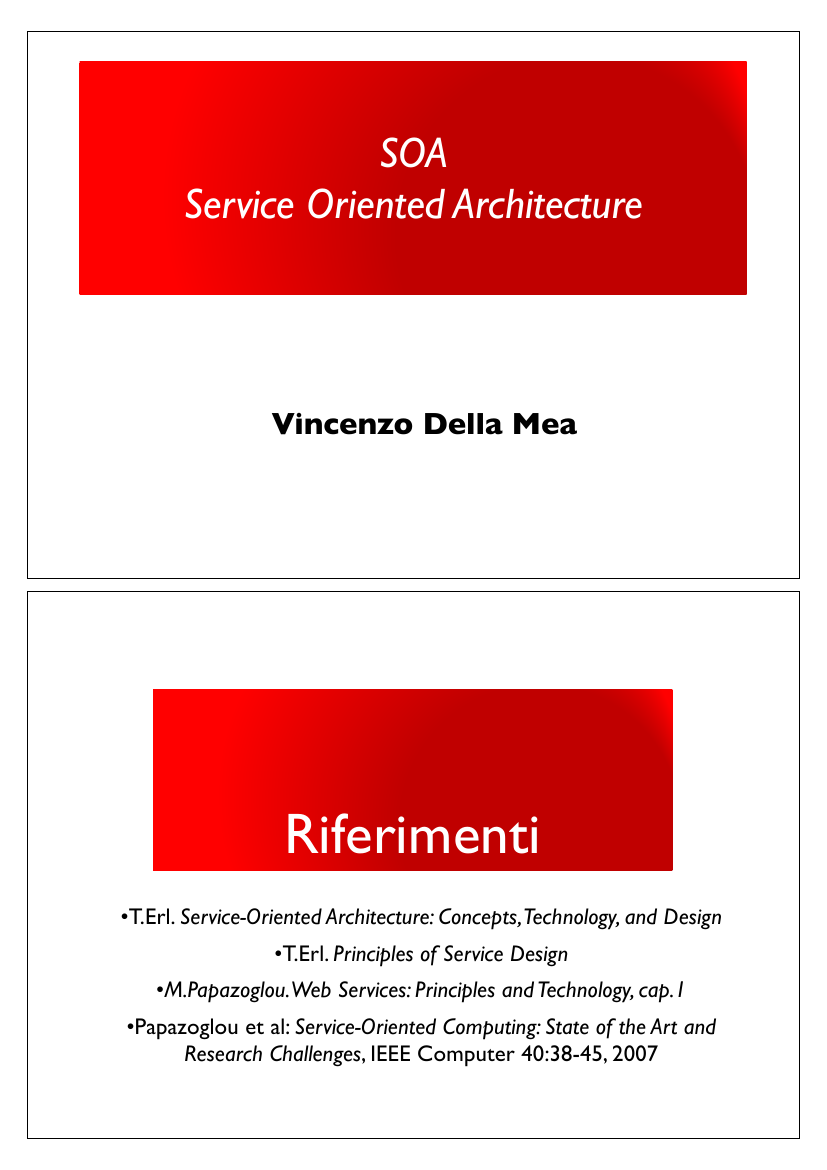


=== Pagina 1/22 ===


Comandi: [v]iew | [vd]ebug | [mb] modify block | [p]rev | [n]ext | [set] parameters | [Q]uit
>  vd


NameError: name 'compute_dark_mask' is not defined

In [286]:
interactive_debug(pages, bounding_args)